In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from SDT import SDT

In [2]:
def onehot_coding(target, device, output_dim):
    """Convert the class labels into one-hot encoded vectors."""
    target_onehot = torch.FloatTensor(target.size()[0], output_dim).to(device)
    target_onehot.data.zero_()
    target_onehot.scatter_(1, target.view(-1, 1), 1.0)
    return target_onehot


# Parameters
input_dim = 28 * 28    # the number of input dimensions
output_dim = 10        # the number of outputs (i.e., # classes on MNIST)
depth = 5              # tree depth
lamda = 1e-3           # coefficient of the regularization term 
weight_decaly = 5e-4   # weight decay
batch_size = 128       # batch size
epochs = 50            # the number of training epochs
log_interval = 100     # the number of batches to wait before printing logs
use_cuda = False       # whether to use GPU

# Model and Optimizer
tree = SDT(input_dim, output_dim, depth, lamda, use_cuda)

# Load data
data_dir = "../Dataset/mnist"

transformer = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(data_dir,
                    train=True,
                    download=True,
                    transform=transformer),
    batch_size=batch_size,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(data_dir,
                    train=False,
                    transform=transformer),
    batch_size=batch_size,
    shuffle=True,
)

device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
tree.load_state_dict(torch.load('tree_state_dict.pth'))
tree.eval()

SDT(
  (inner_nodes): Sequential(
    (0): Linear(in_features=785, out_features=31, bias=False)
    (1): Sigmoid()
  )
  (leaf_nodes): Linear(in_features=32, out_features=10, bias=False)
)

[[ 3.8524475e-03  3.8999883e-03  3.8580194e-03 ...  3.8543269e-03
   3.8515523e-03  3.8695657e-03]
 [ 3.5954647e-05  3.6008627e-05  3.5962064e-05 ...  3.5951984e-05
   3.5979814e-05  3.5981611e-05]
 [-2.3574934e-05 -2.3640623e-05 -2.3776316e-05 ... -2.3676594e-05
  -2.3672825e-05 -2.3504235e-05]
 ...
 [-1.2205329e-05 -1.2547387e-05 -1.2566440e-05 ... -1.2404780e-05
  -1.2466048e-05 -1.2258826e-05]
 [-1.6806857e-04 -1.7288330e-04 -1.7240379e-04 ... -1.6939419e-04
  -1.6785703e-04 -1.6527562e-04]
 [ 3.9761573e-05  3.8555532e-05  3.9618579e-05 ...  3.9385457e-05
   3.8511276e-05  3.8513652e-05]]


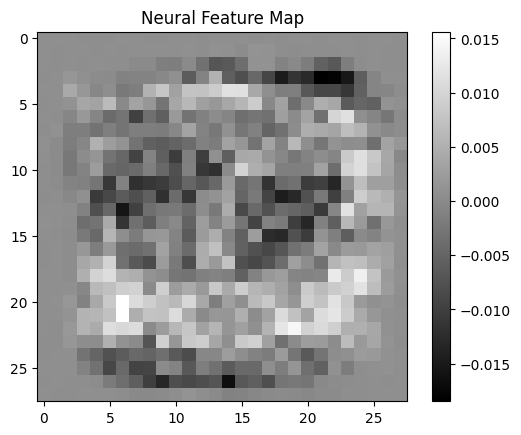

In [4]:
# Load a batch of data from the test_loader or train_loader
data_iter = iter(test_loader)
X, _ = next(data_iter)  # Only fetch the inputs (ignore the targets)

# Move the data to the correct device
# Flatten the images and move to the device
X = X.view(-1, input_dim).to(device)

# Compute the Neural Feature Map for this batch of data
nfm = tree.compute_nfm(X)

# Now `nfm` contains the feature importances, which you can print or analyze further
print(nfm)

# For example, you could visualize the average NFM across all features

# Assuming nfm is a 2D array where the first dimension is the batch size
avg_nfm = nfm.mean(axis=0)  # Average over all samples in the batch

# Reshape to the original image size if necessary (e.g., for MNIST 28x28)
avg_nfm = avg_nfm.reshape(28, 28)

# Plot the average NFM
plt.imshow(avg_nfm, cmap='grey', interpolation='nearest')
plt.colorbar()
plt.title('Neural Feature Map')
plt.show()

In [10]:
outs = tree.forward(X)

In [16]:
_

tensor([1, 6, 0, 7, 1, 7, 1, 7, 4, 6, 9, 3, 2, 3, 3, 1, 3, 2, 1, 1, 8, 6, 7, 0,
        1, 1, 5, 3, 0, 3, 3, 6, 2, 3, 4, 3, 4, 8, 4, 3, 5, 7, 0, 5, 7, 9, 6, 7,
        2, 1, 2, 3, 5, 3, 6, 9, 4, 2, 7, 9, 2, 9, 7, 1, 7, 3, 5, 5, 9, 4, 8, 5,
        7, 4, 6, 9, 2, 9, 1, 0, 3, 3, 7, 3, 4, 9, 7, 2, 2, 9, 8, 7, 5, 6, 4, 9,
        1, 6, 0, 9, 2, 6, 9, 4, 4, 5, 6, 4, 3, 1, 6, 1, 3, 9, 3, 8, 4, 8, 6, 6,
        7, 4, 2, 2, 8, 3, 8, 4])

In [18]:
outs[3]

tensor([-0.7875, -0.5752, -0.6269, -0.5320, -0.6303, -0.7408, -0.7709,  5.5197,
        -0.7314, -0.1491], grad_fn=<SelectBackward0>)